# Gaussian Process samples as Gaussian Random Fields

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal, Covariance
from scipy.linalg import cholesky

## 1D example

Start by generating random fields in one dimension. Here we specify a zero-mean `multivariate_normal` distribution with a covariance matrix computed using the squared exponential function with variance 1 and length scale 0.3. Draw and plot a few samples from this distribution.

The following block uses two key numerical tricks:

 (1) We add a small (1e-6) diagonal term to the covariance matrix. This improves its numerical conditioning, ensuring the computed eigenvalues are striclty positive
 (2) We build the multivariate normal distribution using the cholesky decomposition of the covariance matrix. This further improves the numerical stability of the following computation

In [2]:
# Define a 1D grid and the covariance variance and length scale
x = np.vstack(np.linspace(0, 1, 51))
variance = 1
lengthscale = 0.3

def cov(x1, x2, sigma2, lengthscale):
    c = sigma2 * np.exp(-(x2-x1.T)**2/lengthscale**2)
    # With dense sampling, the pure squared exponential covariance
    # sometimes returns small negative eigenvalues (~ -1e-16)
    # Adding a small diagonal component to the covariance matrix
    # often fixes this
    diag = np.diag(np.ones(len(x2)))
    return 0.5*(c + c.T) + 1e-6*diag

covarray = cov(x, x, variance, lengthscale)
covfactor = cholesky(covarray, lower=True)
covariance = Covariance.from_cholesky(covfactor)

Text(0, 0.5, 'Random field')

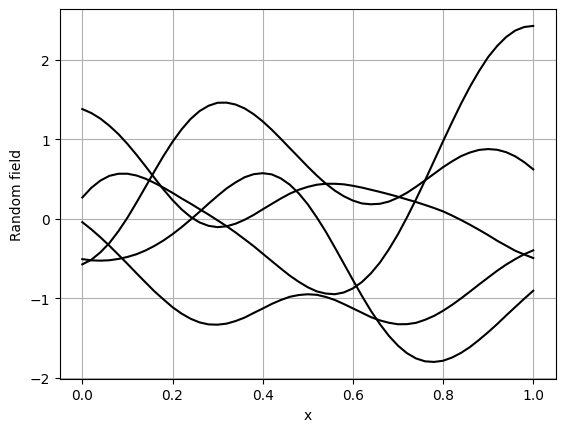

In [3]:
# Draw samples from a multivariate Normal distribution with zero mean and specified covariance
# Try running this cell multiple times to see how the random samples change!
GPsampler = multivariate_normal(cov=covariance)
samples = GPsampler.rvs(size=5)

fig, ax = plt.subplots()
ax.plot(x, samples.T, color='k')
ax.grid()
ax.set_xlabel('x')
ax.set_ylabel('Random field')

## 2D example

Now generalize the above one-dimensional example to two dimensions. For this, we change the `x` (`(n, 1)`) vector to an `(n, 2)` array, where the first column contains the x positions and the second column contains the y positions. We also modify the covariance function to take different length scales for each dimension.

In [4]:
x = np.linspace(0, 1, 51)
y = np.linspace(0, 1, 51)
[xx, yy] = np.meshgrid(x, y)
xvec = xx.flatten()
yvec = yy.flatten()
X = np.array([xvec, yvec]).T

variance = 1
lengthscales = np.array([0.5, 0.3])


def multivariate_cov(x1, x2, sigma2, lengthscales):
    c = sigma2 * np.ones((x1.shape[0], x2.shape[0]))
    n_dim = x1.shape[1]
    for i in range(n_dim):
        c *= np.exp(-(x2[:, i:i+1]-x1[:, i:i+1].T)**2/lengthscales[i]**2)
    diag = np.diag(np.ones(len(x2)))
    return 0.5*(c + c.T) + 1e-6*diag

multivariate_covarray = multivariate_cov(X, X, variance, lengthscales)
multivariate_covfactor = cholesky(multivariate_covarray, lower=True)
multivariate_covariance = Covariance.from_cholesky(multivariate_covfactor)

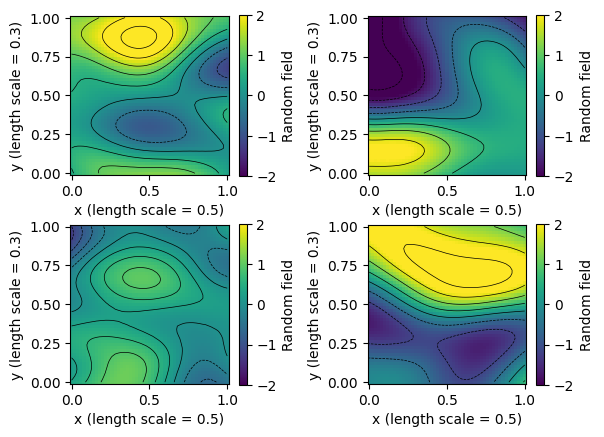

In [5]:
# Draw samples from a multivariate Normal distribution with zero mean and specified covariance
# Try running this cell multiple times to see how the random samples change!
GPsampler = multivariate_normal(cov=multivariate_covariance)
samples = GPsampler.rvs(size=4)

fig, axs = plt.subplots(nrows=2, ncols=2)
for i,ax in enumerate(axs.flat):
    grf = samples[i, :].reshape(xx.shape)
    pc = ax.pcolormesh(xx, yy, grf, vmin=-2, vmax=2)
    ax.contour(xx, yy, grf, colors='k', linewidths=0.5)
    ax.set_xlabel('x (length scale = {:.1f})'.format(lengthscales[0]))
    ax.set_ylabel('y (length scale = {:.1f})'.format(lengthscales[1]))
    ax.set_aspect('equal')
    cbar = fig.colorbar(pc)
    cbar.set_label('Random field')

fig.subplots_adjust(wspace=0.5, hspace=0.3)